In [1]:
# In this notebook, we explore the basic properties of the InstaCart datasets. Our
# mission here is to:
#   1. Familiarize ourselves with the structure of the data sets,
#   2. Understand basic statistics about the data, to get a feel for
#      what we might be able to do with the data
#   3. Assess data quality and perform basic sanity checks. Do the data
#      agree with the claimed specs? Are values missing? Are some values
#      clearly insane and need to be removed?
#   4. Develop a baseline strategy for answering the data challenge.

In [16]:
import pandas as pd
import numpy as np
from math import factorial

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10, 6)


In [4]:
print "Reading orders data ... ",

# The raw data take about 750Mb total on disk.
prior = pd.read_csv('order_products__prior.csv')
train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
departments = pd.read_csv('departments.csv')
products = pd.read_csv('products.csv')
prior = prior.merge(orders, on='order_id', how='left')

print "done."

Reading orders data ...  done.


In [5]:
#
# What is the distribution of basket sizes? How many users do we have?
# How big is the training set? ...
#
basket_sizes = prior.groupby('order_id').apply(len) # number of products per order

# basic summary statistics
min_bs = min(basket_sizes)
max_bs = max(basket_sizes)
pctiles = list(basket_sizes.quantile([0.1, 0.5, 0.9, 0.99]))
print "Total purchases:", len(prior)
print "Total baskets:", len(basket_sizes)
print "Total users:", len(orders.groupby(['user_id']))
print "\tdavon training:", len(train.groupby('order_id'))
print "\tdavon test:", 75000
print
print "Min basket size:", min_bs
print "Max basket size:", max_bs
print "Percentiles:"
print "\t10:", pctiles[0]
print "\t50:", pctiles[1]
print "\t90:", pctiles[2]
print "\t99:", pctiles[3]
print "Avg basket size: %.3f" % basket_sizes.mean()

Total purchases: 32434489
Total baskets: 3214874
Total users: 206209
	davon training: 131209
	davon test: 75000

Min basket size: 1
Max basket size: 145
Percentiles:
	10: 2.0
	50: 8.0
	90: 20.0
	99: 35.0
Avg basket size: 10.089


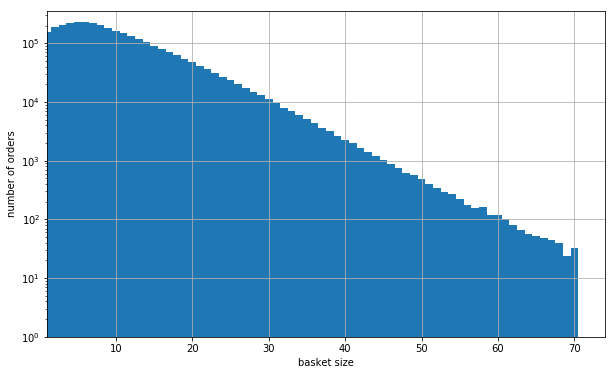

In [28]:
# a visualization of the data from the last cell
bins = np.linspace(0.5, 70.5, 71)
ax = plt.gca()
n, bins, patches = ax.hist(basket_sizes, bins=bins, log = True)
plt.xlabel('basket size')
plt.ylabel('number of orders')
plt.grid()
plt.xlim(xmin=1)
plt.ylim(ymin=1)
plt.show()

In [23]:
#
# Now isn't that a comforting sight? The data contain a lot of structure!!
#
# At least for x > ~20, we see that the basket size in linear on a semilog-y
# scale; we are likely dealing with a geometric distrubition here. This
# distribution could arise very naturally in the following model. Given a
# shopping cart of size k, there is a constant probability p, independent of k,
# that at least one more item will be added to the cart, and a constant
# probability 1 - p that the customer will instead end the shopping trip. Under
# this assumption, we find:
#
#   P(basket size = N) = p**(N-1) * (1-p),
#
# where we use N-1 because the basket is guaranteed to be non-empty.
#
# Due to the initial rise of the distribution from 1 --> 6, this model clearly
# cannot be valid everywhere. We will consider other models below.
#
# Let's try a "fit" to an exponential distribution for "large" basket sizes. A
# simple, albeit crude way to estimate p is to take
#
#   p \approx (# baskets of size 26) / (# baskets of size 25)
#
# I chose sizes 26/25 to be safely away from the regime where the distribution
# is clearly not an exponential distribution but small enough to still have a
# large number of statistics (at 25, we still have ~20,000 representative
# baskets).  We could maybe do better by using the information from all baskets
# above some given basket size, but this is more exact than necessary for our 
# purposes here.
#

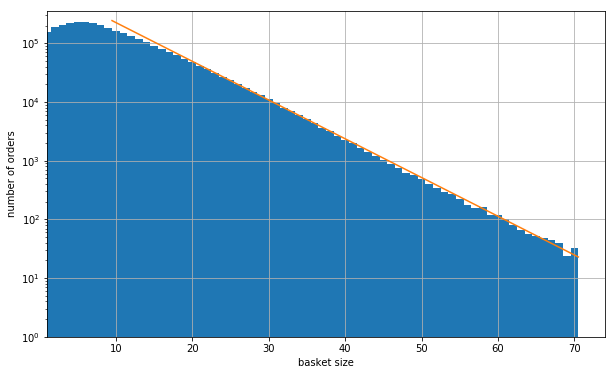

In [29]:
# FIXME: why do I have to do this again? If I don't do this, the figure only 
# shows the exponential fit. This must be some nonsense with the backend behavior ...
ax = plt.gca()
n, bins, patches = ax.hist(basket_sizes, bins=bins, log = True)
plt.xlabel('basket size')
plt.ylabel('number of orders')
plt.grid()
plt.xlim(xmin=1)
plt.ylim(ymin=1)
# END FIXME

rbin = 25 # the basket size we use to calculate the "shopping termination probability"
p = float( len(basket_sizes[basket_sizes == rbin+1]) ) / float( len(basket_sizes[basket_sizes == rbin]) )
assert p < 1

# Generate a geometric distribution with this value of p
sbin = 10 # basket size down to which we will use the model
ebins = bins[bins > sbin - 1]
expdist = p**(ebins - sbin - 1) * (1 - p)

# Normalize only wrt to those points that we think are valid for this model
expdist *= len(basket_sizes[basket_sizes > sbin - 1])
ax.plot(ebins, expdist)
plt.show(ax)

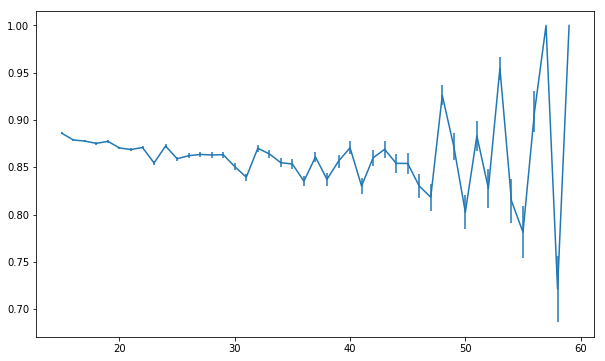

In [30]:
#
# Ok, we fit a line to something that was clearly a line. Great. Nonetheless, 
# the model is probably a good start to understanding to data. However, I 
# note (not shown) that the quality of this fit greatly depends on which bin 
# one uses for computing p. Perhaps, this is not surprising. Customers are not 
# memory-less physical processes. A customer who has spent 10 hours online 
# shopping is more likely to end his shopping experience in the next time unit 
# than one who has spent only 10 minutes shopping.
#

# Here is a visualization of the "shopping termination probability" decreasing
# with shopping duration (or current basket size as a proxy).
ps = []
perr = [] # frequentist estimation error
rbins = range(15, 60)
for rbin in rbins:
    # the basket size we use to calculate the "shopping termination probability"
    ps.append( min(1, float( len(basket_sizes[basket_sizes == rbin+1]) ) / float( len(basket_sizes[basket_sizes == rbin]) )))
    perr.append( np.sqrt(ps[-1] * (1 - ps[-1]) / len(basket_sizes[basket_sizes == rbin])) )

plt.errorbar(rbins, ps, perr)
plt.show()

In [56]:
#
# Another model that I initially considered was that of a Poisson process. Let's
# suppose the customer is mindlessly shopping at 3am because he or she can't
# sleep. Then there is a small but non-zero probability p that he orders any
# given item he is presented with on the shopping interface. After seeing N
# items, the total number of purchased items looks like a Poisson distribution
# with parameter lambda = N * p. Perhaps this model is appropriate for "small"
# basket sizes?? (For large basket sizes, the Poisson distribution falls off too
# fast to be appropriate here.)
#

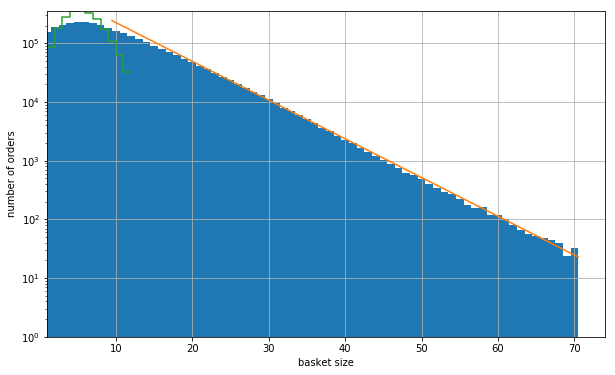

In [33]:
# FIXME: why do I have to do this again? If I don't do this, the figure only 
# shows the exponential fit. This must be some nonsense with the backend behavior ...
ax = plt.gca()
n, bins, patches = ax.hist(basket_sizes, bins=bins, log = True)
plt.xlabel('basket size')
plt.ylabel('number of orders')
plt.grid()
plt.xlim(xmin=1)
plt.ylim(ymin=1)
ax.plot(ebins, expdist)
# END FIXME

pbin = 12 # bin after which we assume Poisson is no good
mu = basket_sizes[basket_sizes <= pbin].mean()
pbins = np.linspace(1, pbin, pbin)
poisson = np.array([np.exp(-mu) * mu**k / factorial(k) for k in pbins])

# Since 0 is not a valid basket size, we need to renormalize the distribution
# (so it adds to 1). We then rescale the distribution by the given sample size
# to interpret it as the expectation value for a sample of this size
#  i.e., < # baskets of size k > = # baskets * P(k)
poisson = len(basket_sizes[basket_sizes <= pbin]) * poisson / sum(poisson)
plt.step(pbins, poisson)
plt.show()

In [69]:
# I haven't gained much confidence that there's anything Poissonian going
# on here ... so it remains to be seen how we should understand the small
# basket size limit ... but we have beat this aspect of the data to death.
# Time to move on.